# Demo
Integrating sub-cellular spots into single-cell level spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('h5ad/snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('h5ad/spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
--- --- --- --- ---



In [6]:
# Step 2. Train a local classifier
clf = pytacs.SVM(threshold_confidence=0.75, log1p=True, normalize=True, on_PCs=False)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [22]:
import dill
with open('trained_clf/clf_SVM_demo.dill', 'wb') as f:
    dill.dump(clf, f)

In [3]:
import dill
with open('trained_clf/clf_SVM_demo.dill', 'rb') as f:
    clf = dill.load(f)
print(clf)

In [4]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=100,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.SVM object at 0x7f14eb053770>
    + threshold_confidence: 0.75
    + has_negative_control: False
- max_spots_per_cell: 100
- scale_rbf: 20.0
- pre-mapped: False
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [5]:
sph.run_preMapping()

1st premapping:   0%|                 | 0/7 [00:00<?, ?it/s]

2nd premapping: 100%|██| 6556/6556 [00:26<00:00, 250.81it/s]


In [6]:
sph.run_segmentation(
    n_spots_add_per_step=10,
    coverage_to_stop=0.99,
    n_parallel=1000,
    max_iter=100,
    verbose=True,
    warnings=False,
    print_summary=True,
)

Iter 1:


Building a batch of cells: 100%|█| 11/11 [15:13<00:00, 83.06


Cell 6161, ... | Confidence: 8.319e-01, ... | Confident total: 791 | class: 0, ...
Classes total: {0: 708, 1: 83}
Coverage: 75.49%
Iter 2:


Building a batch of cells:  45%|▍| 5/11 [10:34<10:08, 101.48IOStream.flush timed out
Building a batch of cells: 100%|█| 11/11 [12:39<00:00, 69.04


Cell 4291, ... | Confidence: 7.604e-01, ... | Confident total: 1489 | class: 0, ...
Classes total: {0: 1332, 1: 157}
Coverage: 94.42%
Iter 3:


Building a batch of cells: 100%|█| 11/11 [02:10<00:00, 11.83


Cell 2092, ... | Confidence: 7.628e-01, ... | Confident total: 1553 | class: 0, ...
Classes total: {0: 1391, 1: 162}
Coverage: 96.00%
Iter 4:
All spots queried.
Done.
--- Summary ---
Queried 2152 spots, of which 1553 made up confident single cells.
Classes total: {0: 1391, 1: 162}
Coverage: 96.00%
--- --- --- --- ---



DEBUG: i_sample=0 new_id=1
DEBUG: i_sample=1 new_id=1
DEBUG: i_sample=2 new_id=493
DEBUG: i_sample=3 new_id=493
DEBUG: i_sample=4 new_id=493
DEBUG: i_sample=5 new_id=5
DEBUG: i_sample=6 new_id=493
DEBUG: i_sample=7 new_id=5
DEBUG: i_sample=8 new_id=8
DEBUG: i_sample=9 new_id=5
DEBUG: i_sample=10 new_id=10
DEBUG: i_sample=11 new_id=-1
DEBUG: i_sample=12 new_id=157
DEBUG: i_sample=13 new_id=-1
DEBUG: i_sample=14 new_id=306
DEBUG: i_sample=15 new_id=15
DEBUG: i_sample=16 new_id=82
DEBUG: i_sample=17 new_id=173
DEBUG: i_sample=18 new_id=173
DEBUG: i_sample=19 new_id=173
DEBUG: i_sample=20 new_id=20
DEBUG: i_sample=21 new_id=173
DEBUG: i_sample=22 new_id=173
DEBUG: i_sample=23 new_id=-1
DEBUG: i_sample=24 new_id=24
DEBUG: i_sample=25 new_id=30
DEBUG: i_sample=26 new_id=322
DEBUG: i_sample=27 new_id=322
DEBUG: i_sample=28 new_id=322
DEBUG: i_sample=29 new_id=322
DEBUG: i_sample=30 new_id=30
DEBUG: i_sample=31 new_id=30
DEBUG: i_sample=32 new_id=30
DEBUG: i_sample=33 new_id=30
DEBUG: i_sample

<Axes: >

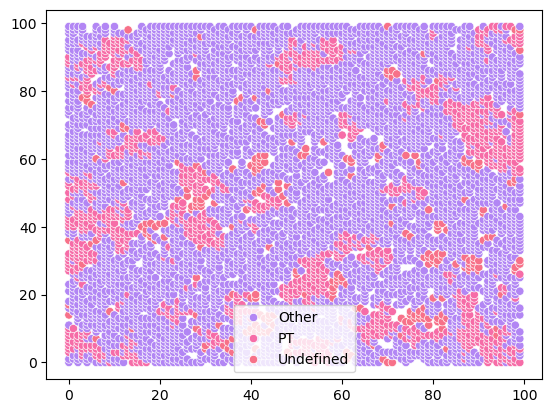

In [7]:
# See type predictions
sph.run_plotClasses()

In [8]:
# Step 4. Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)
print(sp_singleCell)

AnnData object with n_obs × n_vars = 1553 × 5227
    obs: 'x', 'y', 'old_index', 'cell_type_premapping2', 'confidence', 'cell_type'


In [9]:
sp_singleCell.obs.head()

,x,y,old_index,cell_type_premapping2,confidence,cell_type
1,0,1,"0,1",0,0.884980,0
5,0,6,"0,6",1,0.818532,0
8,0,9,"0,9",1,0.815924,0
10,0,11,"0,11",0,0.772159,0
15,0,21,"0,21",0,0.772159,0
